## Introduction

### [Zenodo Mental Health Issues Datasets](https://zenodo.org/records/3941387?utm_source=chatgpt.com)

These datasets originated from Reddit posts between 2018-2020, and are subject to 15 mental health issues :

![alt text](../cleaning_notebooks/images/image.png)

Each mental health issue has between 3 or 4 datasets. As e.g.

- 4 datasets are proposed for addiction mental health issue :

![alt text](../cleaning_notebooks/images/image-1.png)

- whereas for EDAnonymous (struggles related to eating disorder), only 3 datasets are found :

![alt text](../cleaning_notebooks/images/image-2.png)

EDAnonymous was the only mental health disorder with 3 datasets.

When considering for e.g. only one specific dataset, each post comes from a unique user id ; but we can't be sure that a user id can't have post in two different datasets.


### [Kaggle Mental Health Corpus Dataset](https://www.kaggle.com/datasets/reihanenamdari/mental-health-corpus/data)

This dataset could also be found on also found on HuggingFace with the link https://huggingface.co/datasets/joangaes/depression.

It's a collection of texts/sentences related to people with anxiety, depression, and other mental health issues (other not being disclosed by the dataset creator).

In this dataset, we are interested into texts not related to mental health issues.

For this dataset, we have no mention about its source and we can't neither affirm that each post comes from a unique person or even a person or generated using AI.

### Datasets storage

- Original Zenodo and Kaggle datasets were downloaded locally from those websites : [Kaggle Mental Health Corpus Dataset](https://www.kaggle.com/datasets/reihanenamdari/mental-health-corpus/data), [Zenodo Mental Health Issues Datasets](https://zenodo.org/records/3941387?utm_source=chatgpt.com). They were preprocessed a little bit, to be ready for models' training.

- Clean datasets (train_validation, test sets), obtained after cleaning process, are also found on a [public Hugging Face repository](https://huggingface.co/datasets/pfacouetey/DSTI_Deep_Learning_Project_2025_CLEAN)


## Import needed libraries

In [1]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from sklearn.model_selection import train_test_split
from emot.emo_unicode import EMOTICONS_EMO
from nltk.tokenize import sent_tokenize
from huggingface_hub import HfApi
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from tqdm import tqdm
import pandas as pd
import emoji
import nltk
import torch
import glob
import gc
import re
import os

tqdm.pandas()
load_dotenv()

# Download punkt tokenizer for sentence splitting
nltk.download("punkt")
nltk.download("punkt_tab")

api = HfApi(token=os.getenv("HF_TOKEN")) # Set up HuggingFace API with My Secret

SEED = 123 # A seed to reproduce any stochastic process done

CLEAN_DATA_PATH = 'pfacouetey/DSTI_Deep_Learning_Project_2025' # Data path to upload clean datasets

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\acoue\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\acoue\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
# A quick process function to remove emoji, transform them and remove any unwanted spaces

def _clean_a_text(text: str) -> str:
    return re.sub(r'\s+', ' ', str(text.lower()).strip())

emoticon_pattern = re.compile('|'.join(map(re.escape, EMOTICONS_EMO.keys())))
def _replace_emojis_and_emoticons(text: str) -> str:
    text = emoji.demojize(text)
    def replace_match(match):
        emoticon = match.group(0)
        return f":{EMOTICONS_EMO[emoticon][1]}:"
    return emoticon_pattern.sub(replace_match, text)

def quick_process_on_texts(df: pd.DataFrame, cols_to_keep=['text', 'label', 'text_length']) -> pd.DataFrame:
    df['text'] = df['text'].apply(_clean_a_text)
    df['text'] = df['text'].apply(_replace_emojis_and_emoticons)
    df['text_length'] = df['text'].str.len()
    mask_validrows = df['text'].str.strip() != ''
    df = df[mask_validrows]
    return df[cols_to_keep]

In [3]:
# A quick process to correct texts grammatically, remove redundancy and summarize them

# Load grammar correction model
grammar_model_name = "vennify/t5-base-grammar-correction"
grammar_tokenizer = AutoTokenizer.from_pretrained(grammar_model_name)
grammar_model = AutoModelForSeq2SeqLM.from_pretrained(grammar_model_name)

# Load summarization model
summarization_model_name = "Falconsai/text_summarization"
summarization_tokenizer = AutoTokenizer.from_pretrained(summarization_model_name)
summarization_model = AutoModelForSeq2SeqLM.from_pretrained(summarization_model_name, force_download=True)

# Use CPU explicitly for consistency and efficiency
device = "cpu"
grammar_model = grammar_model.to(device)
summarization_model = summarization_model.to(device)

# Set models to eval mode
grammar_model.eval()
summarization_model.eval()

# Batch correct a list of sentences
def _batch_correct(sentences, batch_size=16):
    corrected = []
    with torch.inference_mode():
        for i in range(0, len(sentences), batch_size):
            batch = sentences[i:i+batch_size]
            inputs = grammar_tokenizer(
                ["gec: " + s for s in batch],
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=512
            )
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = grammar_model.generate(
                **inputs,
                num_beams=5,
                min_length=1,
                repetition_penalty=10.0,
                no_repeat_ngram_size=2,
            )
            decoded = grammar_tokenizer.batch_decode(outputs, skip_special_tokens=True)
            corrected.extend(decoded)
    return corrected

# Correct a batch of texts (each text split into sentences)
def _batch_correct_texts(texts, batch_size=16):
    all_sentences = []
    batch_lens = []
    for text in texts:
        sents = sent_tokenize(text)
        all_sentences.extend(sents)
        batch_lens.append(len(sents))
    corrected_sentences = _batch_correct(all_sentences, batch_size)
    corrected_texts = []
    idx = 0
    for length in batch_lens:
        corrected_text = " ".join(corrected_sentences[idx:idx+length])
        corrected_texts.append(corrected_text)
        idx += length
    return corrected_texts

# Batch summarize chunks of one or more texts
def _batch_summarize(chunks, batch_size=16):
    summaries = []
    with torch.inference_mode():
        for i in range(0, len(chunks), batch_size):
            batch = chunks[i:i+batch_size]
            inputs = summarization_tokenizer(
                batch,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=512
            )
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = summarization_model.generate(
                **inputs,
                num_beams=4,
                max_length=100,
                early_stopping=True
            )
            decoded = summarization_tokenizer.batch_decode(outputs, skip_special_tokens=True)
            summaries.extend(decoded)
    return summaries

# Split text into chunks by tokens (for summarization)
def split_text_into_chunks(text, max_chunk_size=512):
    sentences = sent_tokenize(text)
    chunks, current_chunk, current_len = [], [], 0
    for sent in sentences:
        length = len(sent.split())
        if current_len + length <= max_chunk_size:
            current_chunk.append(sent)
            current_len += length
        else:
            chunks.append(" ".join(current_chunk))
            current_chunk = [sent]
            current_len = length
    if current_chunk:
        chunks.append(" ".join(current_chunk))
    return chunks

# Batch summarize multiple texts hierarchically
def _batch_summarize_texts(texts, batch_size=16):
    all_final_summaries = []
    for text in texts:
        chunks = split_text_into_chunks(text)
        chunk_summaries = _batch_summarize(chunks, batch_size)
        # Recursively summarize if more than one chunk summary remains
        while len(chunk_summaries) > 1:
            combined = " ".join(chunk_summaries)
            chunk_summaries = _batch_summarize([combined], batch_size)
        all_final_summaries.append(chunk_summaries[0])
    return all_final_summaries

# Full pipeline batch version
def clean_and_summarize_batch(texts, correction_batch=16, summarization_batch=16):
    corrected_texts = _batch_correct_texts(texts, batch_size=correction_batch)
    summaries = _batch_summarize_texts(corrected_texts, batch_size=summarization_batch)
    return summaries

# Apply full batch pipeline on pandas DataFrame column in batches
def clean_and_summarize_dataframe_batch(df, text_col="text", batch_size=16):
    texts = df[text_col].tolist()
    results = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Batch processing DataFrame"):
        batch_texts = texts[i:i+batch_size]
        batch_summaries = clean_and_summarize_batch(batch_texts, correction_batch=batch_size, summarization_batch=batch_size)
        results.extend(batch_summaries)
    df = df.copy()
    df[text_col] = results
    return df

## Get downloaded data

In [4]:
# Get current notebook directory (notebooks/)
current_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in locals() else os.getcwd()

# Paths to data folders relative to notebook
zenodo_data_path = os.path.join(current_dir, "..", "data", "raw_version", "zenodo_data")
kaggle_data_path = os.path.join(current_dir, "..", "data", "raw_version", "kaggle_data")

# Find all CSVs
zenodo_csvs = glob.glob(os.path.join(zenodo_data_path, "*.csv"))
zenodo_dfs = [pd.read_csv(f) for f in zenodo_csvs]
assert len(zenodo_dfs) == (14*4 + 3*1)

kaggle_csv = glob.glob(os.path.join(kaggle_data_path, "*.csv"))
assert len(kaggle_csv) == 1
kaggle_df = pd.read_csv(kaggle_csv[-1])

## A quick view on dowloaded data before some simple processing

In [5]:
zenodo_dfs[0].head(n=1)

,subreddit,author,date,post,automated_readability_index,coleman_liau_index,flesch_kincaid_grade_level,flesch_reading_ease,gulpease_index,gunning_fog_index,...,tfidf_wish,tfidf_without,tfidf_wonder,tfidf_work,tfidf_worri,tfidf_wors,tfidf_would,tfidf_wrong,tfidf_x200b,tfidf_year
0,addiction,SearchSmegmaongoogle,2018/01/01,Deciding to go of tramadol Well after never ta...,5.651264,5.245836,6.314583,81.454306,67.25,8.861111,...,0.299199,0.0,0.0,0.0,0.0,0.132575,0.0,0.0,0.0,0.0


In [6]:
zenodo_dfs[-1].head(n=1)

,subreddit,author,date,post,automated_readability_index,coleman_liau_index,flesch_kincaid_grade_level,flesch_reading_ease,gulpease_index,gunning_fog_index,...,tfidf_wish,tfidf_without,tfidf_wonder,tfidf_work,tfidf_worri,tfidf_wors,tfidf_would,tfidf_wrong,tfidf_x200b,tfidf_year
0,suicidewatch,pleasethinkIogically,2018/11/28,"I want to kill myself, but my ex (who I would ...",0.728582,2.601987,2.020442,98.702414,82.236994,4.76423,...,0.0,0.0,0.0,0.0,0.126368,0.0,0.176788,0.0,0.0,0.080131


In [7]:
kaggle_df.sample(n=10, random_state=SEED)

,text,label
3525,little hobby finding really cool pics pretty m...,0
6177,blasting music laying bed couldnt go party do ...,0
16590,ask crush phone number andor social media ive ...,0
15483,legend got released today week ago week ago fu...,0
20413,wish knew start post a year old cis white mar...,1
25781,theres pointim atheist british teenager see po...,1
26323,m decided deadlinenow deadline im rn turn se...,1
21353,tbh think get betterive lurked reddit now ofte...,1
17638,stop giving cat milk cats lactose intolerant h...,0
23122,messed big told best friend feelings shut down...,0


- For zenodo datasets, columns 'post' and 'subreddit' are the only ones needed.
- For kaggle dataset, all columns are kept but we're interested in rows with column 'label' equals to 0 (normal samples).

## A quick process on kaggle and zenodo datasets

In [8]:
processed_dfs_list = []
for df in zenodo_dfs:
    raw_df = df[['post', 'subreddit']].copy()
    raw_df = raw_df.rename(columns={'post': 'text', 'subreddit': 'label'})
    processed_df = quick_process_on_texts(df=raw_df)
    processed_dfs_list.append(processed_df)
    del raw_df, processed_df
    
zenodo_whole_df = pd.concat(processed_dfs_list, axis=0, ignore_index=True)

del processed_dfs_list
gc.collect()

3875

In [9]:
# Make sure any empty text is still not present
assert (zenodo_whole_df['text_length'] > 0).all() 

# Remove any unexpected duplicated text
zenodo_whole_df = zenodo_whole_df.drop_duplicates().dropna(axis=0).sort_values(by='text_length', ascending=True) 

# Make sure that all 15 specific mental health issues info are being kept
assert zenodo_whole_df['label'].nunique() == 15 

print(f"We have in total {len(zenodo_whole_df)} samples of {zenodo_whole_df['label'].nunique()} mental health issues from ZENODO.")

We have in total 394900 samples of 15 mental health issues from ZENODO.


In [10]:
zenodo_whole_df.head(n=10)

,text,label,text_length
410421,is k,suicidewatch,4
409747,cum cum,suicidewatch,7
420726,help me,suicidewatch,7
366642,i worthl,suicidewatch,8
415384,i’m done .,suicidewatch,10
314335,iamme tsol,lonely,10
202539,help please,depression,11
419363,i'm ugly. .,suicidewatch,11
411811,. i give up,suicidewatch,11
373575,:a: i tried,suicidewatch,11


In [11]:
# A representation of all mental health issues
zenodo_whole_df['label'].value_counts()

label
depression       113560
suicidewatch      62010
anxiety           53795
adhd              41356
bpd               21846
lonely            21447
socialanxiety     19719
EDAnonymous       13448
healthanxiety      7865
autism             7751
schizophrenia      7685
ptsd               7569
addiction          6570
bipolarreddit      5195
alcoholism         5084
Name: count, dtype: int64

In [12]:
kaggle_normal_df = kaggle_df.copy()

# Process texts
kaggle_normal_df = quick_process_on_texts(df=kaggle_normal_df) 

# Keep only normal samples
mask_normal_samples = kaggle_normal_df['label'] == 0
kaggle_normal_df = kaggle_normal_df[mask_normal_samples].replace(0, "normal")

# Make sure any empty text is still not present
assert (kaggle_normal_df['text_length'] > 0).all() 

# Remove any unexpected duplicated text
kaggle_normal_df = kaggle_normal_df.drop_duplicates().dropna(axis=0).sort_values(by='text_length', ascending=True) 

# Make sure that only normal samples are kept
assert kaggle_normal_df['label'].unique() == 'normal' 

print(f"We have in total {len(kaggle_normal_df)} samples without any mental health issue from KAGGLE.")

We have in total 14132 samples without any mental health issue from KAGGLE.


In [13]:
kaggle_normal_df.head(n=10)

,text,label,text_length
13268,im,normal,2
22095,yes,normal,3
2781,male,normal,4
25843,cout,normal,4
25772,feel,normal,4
654,sleep,normal,5
15583,fap i,normal,5
20782,bf pog,normal,6
10560,moment,normal,6
1811,karent,normal,6


## A quick view on all texts length

In [14]:
raw_data_df = pd.concat([zenodo_whole_df, kaggle_normal_df], axis=0).copy().reset_index(drop=True)
raw_data_df['text_length'] = raw_data_df['text_length'].astype(int)

raw_data_df.head()

,text,label,text_length
0,is k,suicidewatch,4
1,cum cum,suicidewatch,7
2,help me,suicidewatch,7
3,i worthl,suicidewatch,8
4,i’m done .,suicidewatch,10


In [15]:
raw_data_df['label'].value_counts()

label
depression       113560
suicidewatch      62010
anxiety           53795
adhd              41356
bpd               21846
lonely            21447
socialanxiety     19719
normal            14132
EDAnonymous       13448
healthanxiety      7865
autism             7751
schizophrenia      7685
ptsd               7569
addiction          6570
bipolarreddit      5195
alcoholism         5084
Name: count, dtype: int64

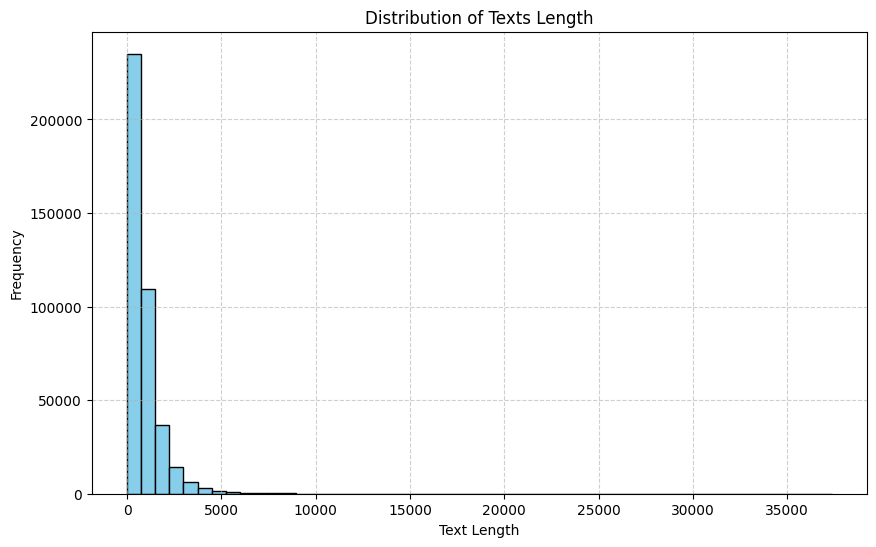

In [16]:
# Distribution of the text_length in column 'text'
plt.figure(figsize=(10, 6))
plt.hist(raw_data_df['text_length'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Texts Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [17]:
raw_data_df['text_length'].describe()

count    409032.000000
mean        894.492839
std         918.883269
min           2.000000
25%         335.000000
50%         634.000000
75%        1136.000000
max       37358.000000
Name: text_length, dtype: float64

In [18]:
# Shortest text
print(raw_data_df[raw_data_df['text_length'] == raw_data_df['text_length'].min()]['text'])

394900    im
Name: text, dtype: object


In [19]:
# Largest text
print(raw_data_df[raw_data_df['text_length'] == raw_data_df['text_length'].max()]['text'])

394899    my social anxiety had returned and its killing...
Name: text, dtype: object


Data is quite diverse in length : from shot texts (two-character long) to whole paragraphs (37358-character long)

## A quick sampling on whole data to have balanced classes

In [20]:
MAX_SAMPLES_PER_CLASS = 5000 # We decided to have around 5000 samples at most per class

In [21]:
mental_health_classes = raw_data_df['label'].unique().tolist()
sampled_raw_data_df = pd.DataFrame(columns=['text', 'label'])

for mental_health in mental_health_classes:
    df = raw_data_df[raw_data_df['label'] == mental_health].copy()
    sampled_df = df.sample(n=min(MAX_SAMPLES_PER_CLASS, df.shape[0]), random_state=SEED)

    print(f'{mental_health.upper()}: {sampled_df.shape[0]} samples.')
    sampled_raw_data_df = pd.concat([sampled_raw_data_df, sampled_df], axis=0).reset_index(drop=True)

    del sampled_df, df

SUICIDEWATCH: 5000 samples.
LONELY: 5000 samples.
DEPRESSION: 5000 samples.
SCHIZOPHRENIA: 5000 samples.
ANXIETY: 5000 samples.
EDANONYMOUS: 5000 samples.
BPD: 5000 samples.
ADHD: 5000 samples.
ALCOHOLISM: 5000 samples.
AUTISM: 5000 samples.
SOCIALANXIETY: 5000 samples.
BIPOLARREDDIT: 5000 samples.
HEALTHANXIETY: 5000 samples.
ADDICTION: 5000 samples.
PTSD: 5000 samples.
NORMAL: 5000 samples.


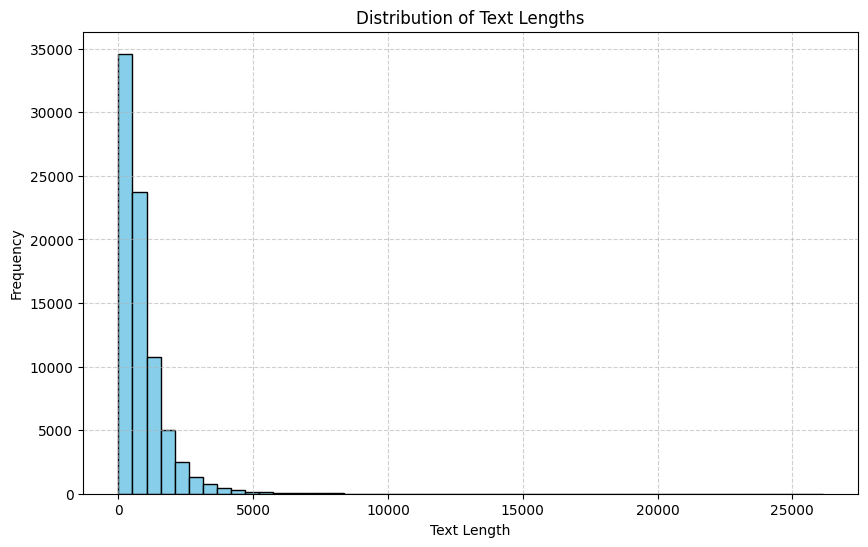

In [22]:
# Distribution of the text_length in column 'text'
sampled_raw_data_df['text_length'] = sampled_raw_data_df['text'].apply(len)

plt.figure(figsize=(10, 6))
plt.hist(sampled_raw_data_df['text_length'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [23]:
del sampled_raw_data_df['text_length']

In [24]:
sampled_raw_data_df.shape

(80000, 2)

## Use a grammatical corrector, then summarize all sampled texts

For texts' grammar corrections, we use the [model vennify/t5-base-grammar-correction](https://huggingface.co/vennify/t5-base-grammar-correction) which is currently one of the most popular on Hugging Face.

For summarization, we use the [Falconsai/text_summarization model](https://huggingface.co/Falconsai/text_summarization) model.

Both models are kind of lightweight (can be run locally), and provide quite good results.

In [25]:
# Run texts' correction and summarization once, save results so next time only loadings will be done
try:
    clean_data_df = pd.read_csv('clean_data.csv')
except FileNotFoundError:
    clean_data_df = clean_and_summarize_dataframe_batch(sampled_raw_data_df)
    clean_data_df.to_csv('clean_data.csv', index=False)

## Split data into train and test sets

In [26]:
X, y = sampled_raw_data_df['text'], sampled_raw_data_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

train_df = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
test_df = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

print(f'In train we have {len(train_df)} samples, whereas test has {len(test_df)} samples.')

In train we have 64000 samples, whereas test has 16000 samples.


In [27]:
train_df.head(n=10)

,text,label
0,sub for alcoholics over 30 or 40? i am looking...,alcoholism
1,i’m sick of lashing out i know that a huge par...,bpd
2,"seeking advice hello all, i do not know if thi...",bpd
3,confused and lost? minor tw// i briefly mentio...,ptsd
4,my brain is so foggy and i’m so exhausted the ...,EDAnonymous
5,first psychiatrist therapy session led to iden...,bpd
6,do you ever feel like you’re screaming at your...,adhd
7,food doesn’t taste great i can’t pinpoint when...,depression
8,mania who the fuck holds the strings to manic ...,bipolarreddit
9,someone please murder me.... i don’t have a lo...,suicidewatch


In [28]:
train_df['label'].value_counts(normalize=True)

label
adhd             0.063641
healthanxiety    0.062828
bipolarreddit    0.062750
socialanxiety    0.062687
bpd              0.062641
normal           0.062578
autism           0.062516
ptsd             0.062500
alcoholism       0.062484
suicidewatch     0.062484
depression       0.062484
anxiety          0.062437
lonely           0.062141
EDAnonymous      0.062047
schizophrenia    0.062031
addiction        0.061750
Name: proportion, dtype: float64

In [29]:
test_df.head(n=10)

,text,label
0,is anxiety something that therapy can really f...,anxiety
1,editor voice applications and maybe drawing ap...,normal
2,dealing with alcoholic mother it’s been about ...,alcoholism
3,becoming a hermit just wondering if anyone els...,EDAnonymous
4,i’m too stoned high i’m gonna make this quick ...,anxiety
5,hello hi im drunk af olz stop in and sy hello ...,addiction
6,must say movie truly amazing heartwarming rees...,normal
7,today is a nightmare. please just tell me it w...,anxiety
8,bee sting i got stung by a bee earlier today. ...,healthanxiety
9,going back to college in two weeks send help. ...,bipolarreddit


In [30]:
test_df['label'].value_counts(normalize=True)

label
addiction        0.065500
schizophrenia    0.064375
EDAnonymous      0.064312
lonely           0.063937
anxiety          0.062750
depression       0.062562
suicidewatch     0.062562
alcoholism       0.062562
ptsd             0.062500
autism           0.062437
normal           0.062187
bpd              0.061937
socialanxiety    0.061750
bipolarreddit    0.061500
healthanxiety    0.061187
adhd             0.057938
Name: proportion, dtype: float64

In [31]:
X, y = clean_data_df['text'], clean_data_df['label']
clean_X_train, clean_X_test, clean_y_train, clean_y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

train_clean_df = pd.concat([clean_X_train, clean_y_train], axis=1).reset_index(drop=True)
test_clean_df = pd.concat([clean_X_test, clean_y_test], axis=1).reset_index(drop=True)

print(f'In train we have {len(train_clean_df)} samples, whereas test has {len(test_clean_df)} samples.')

In train we have 64000 samples, whereas test has 16000 samples.


In [32]:
train_clean_df.head(n=10)

,text,label
0,30 or 40? I am looking for subs for seasoned a...,alcoholism
1,I need help. Does anyone have any tips for hel...,bpd
2,"advice Hello all, I do not know if this is all...",bpd
3,I was sexually assaulted ok so recently got di...,ptsd
4,My brain is so foggy and I’m exhausted. My bra...,EDAnonymous
5,"led to identity crisis hi there, I'm new here....",bpd
6,Do you ever feel like you’re screaming at your...,adhd
7,It sucks that I can’t seem to enjoy it. Most o...,depression
8,the fuck holds the strings to manic episodes? ...,bipolarreddit
9,please murder me.... I don’t have much money t...,suicidewatch


In [33]:
test_clean_df.head(n=10)

,text,label
0,is something I can suppress. It’s crippling an...,anxiety
1,Editor voice applications voice applications a...,normal
2,I’ve been dealing with my alcoholic mom for so...,alcoholism
3,. I haven’t gained weight since the last time ...,EDAnonymous
4,I’m too stoned high and I'm gonna make this qu...,anxiety
5,"Hello, I'm drunk after olz stop in and say hel...",addiction
6,Must say movie truly amazing heartwarming rees...,normal
7,is a nightmare. Please just tell me it will be...,anxiety
8,sting I got stung by a bee earlier today. It's...,healthanxiety
9,to finish their degree and find a good job aft...,bipolarreddit


## Save train and test sets as .feather files

In [34]:
# Optimize columns' types before saving
train_df = train_df.astype("category")
test_df = test_df.astype("category")
train_clean_df = train_clean_df.astype("category")
test_clean_df = test_clean_df.astype("category")

# Define output directories relative to notebook
local_out_dir = os.path.join(current_dir, '..', 'data', 'clean_version')
train_filename, test_filename = 'train.feather', 'test.feather'
clean_train_filename, clean_test_filename = 'train2.feather', 'test2.feather'

# Compress data as much as we can into .feather format before uploading them on HuggingFace
train_df.to_feather(os.path.join(local_out_dir, train_filename), compression="zstd", compression_level=22)
test_df.to_feather(os.path.join(local_out_dir, test_filename), compression="zstd", compression_level=22)
train_clean_df.to_feather(os.path.join(local_out_dir, clean_train_filename), compression="zstd", compression_level=22)
test_clean_df.to_feather(os.path.join(local_out_dir, clean_test_filename), compression="zstd", compression_level=22)

In [35]:
# Upload files on HuggingFace public repo
api.upload_file(
    path_or_fileobj=os.path.join(local_out_dir, train_filename),
    path_in_repo=train_filename,
    repo_id=CLEAN_DATA_PATH,
    repo_type="dataset"
)
api.upload_file(
    path_or_fileobj=os.path.join(local_out_dir, test_filename),
    path_in_repo=test_filename,
    repo_id=CLEAN_DATA_PATH,
    repo_type="dataset"
)
api.upload_file(
    path_or_fileobj=os.path.join(local_out_dir, clean_train_filename),
    path_in_repo=clean_train_filename,
    repo_id=CLEAN_DATA_PATH,
    repo_type="dataset"
)
api.upload_file(
    path_or_fileobj=os.path.join(local_out_dir, clean_test_filename),
    path_in_repo=clean_test_filename,
    repo_id=CLEAN_DATA_PATH,
    repo_type="dataset"
)

Processing Files (1 / 1): 100%|██████████| 14.1MB / 14.1MB,  0.00B/s  
New Data Upload: |          |  0.00B /  0.00B,  0.00B/s  
No files have been modified since last commit. Skipping to prevent empty commit.
Processing Files (1 / 1): 100%|██████████| 3.72MB / 3.72MB,  0.00B/s  
New Data Upload: |          |  0.00B /  0.00B,  0.00B/s  
No files have been modified since last commit. Skipping to prevent empty commit.
Processing Files (1 / 1): 100%|██████████| 4.78MB / 4.78MB,  0.00B/s  
New Data Upload: |          |  0.00B /  0.00B,  0.00B/s  
No files have been modified since last commit. Skipping to prevent empty commit.
Processing Files (1 / 1): 100%|██████████| 1.27MB / 1.27MB,  0.00B/s  
New Data Upload: |          |  0.00B /  0.00B,  0.00B/s  
No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/datasets/pfacouetey/DSTI_Deep_Learning_Project_2025/commit/d57b122c592b2f5005beb9b2cf2cbc1e77d20aa7', commit_message='Upload test2.feather with huggingface_hub', commit_description='', oid='d57b122c592b2f5005beb9b2cf2cbc1e77d20aa7', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/pfacouetey/DSTI_Deep_Learning_Project_2025', endpoint='https://huggingface.co', repo_type='dataset', repo_id='pfacouetey/DSTI_Deep_Learning_Project_2025'), pr_revision=None, pr_num=None)